In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
RANDOM_ALGORITHM = "random"
K_MEANS_PP_ALGORITHM = 'k-means++'

In [3]:
class KMeansClustering:
    def __init__(self,k,centroids_algorithm = RANDOM_ALGORITHM,print_chosen_centroids=False):
        self.k = k
        self.best_performance = np.inf
        self.centroids_matrix = None
        self.centroids_algorithm = centroids_algorithm
        self.print_chosen_centroids = print_chosen_centroids

    def __init_centroids(self,X):
        if self.centroids_algorithm == RANDOM_ALGORITHM:
            return X[np.random.choice(range(len(X)),self.k)]
        if self.centroids_algorithm == K_MEANS_PP_ALGORITHM:
            #Need to implement
            return self.__kpp_centroids(X)

    def __kpp_centroids(self,X):
        random_index = np.random.randint(0,len(X))
        centroids = [ X[random_index] ]
        centroid_indexes = [random_index]
        for i in range(self.k-1):
            distances = np.zeros(len(X))
            for centroid in centroids:
                centroid_distances = np.sum((X-centroid)**2,axis=1)
                distances += centroid_distances  
            distances = distances/sum(distances)
            new_centroid_index = centroid_indexes[0]
            while new_centroid_index in centroid_indexes:
                #Choose new centroid with the probabilities being the ditances from previous centroids
                new_centroid_index = np.random.choice(range(len(X)),p=distances)
            new_centroid = X[new_centroid_index]
            centroids.append(X[new_centroid_index])
        centroids = np.array(centroids).reshape((self.k,X.shape[1]))
        return centroids
                
            
    
    def __calcualte_centroids(self,X,labels):
        unique_labels = np.unique(labels)
        centroids = []
        for i,label in enumerate(unique_labels):
            label_data = X[labels == label]
            centroid = self.__calculate_centroid(label_data)
            centroids.append(centroid)
        return np.array(centroids)

    def __check_centroids_dissapeared(self,labels):
        return self.k - len(np.unique(labels))

    def __add_centroids(self,X,centroids,amount):
        new_centroids = X[np.random.choice(range(len(X)),amount)]
        return np.vstack([centroids,new_centroids])

    def __round(self,X,r=0):
        prev_centroids = self.__init_centroids(X)
        if self.print_chosen_centroids:
            fig, axs = plt.subplots(1, 2, figsize=(4, 2))
            
            sns.scatterplot(x=X[:, 0], y=X[:, 1] , ax=axs[0])
            axs[0].set_title("All data points ")
            
            x_limits = axs[0].get_xlim()
            y_limits = axs[0].get_ylim()
            
            sns.scatterplot(x=prev_centroids[:, 0], y=prev_centroids[:, 1], ax=axs[1])
            axs[1].set_title("Initial centroids chosen by \n " + str (self.centroids_algorithm) + " algorithm \n at round " + str(r))
            
            axs[1].set_xlim(x_limits)
            axs[1].set_ylim(y_limits)
            
            plt.tight_layout()
            plt.show()
        
        centroids = None
        while True:
            labels = self.__classify_points(X,prev_centroids)
            centroids = self.__calcualte_centroids(X,labels)
            #Checking if a centorid dissapeared and adding one again if yes
            centroids_lost = self.__check_centroids_dissapeared(labels) 
            if  centroids_lost != 0:
                centroids = self.__add_centroids(X,centroids,centroids_lost)
            if self.__centroids_equal(prev_centroids,centroids):
                break
            prev_centroids = centroids
        return centroids

    def __centroids_error(self,X,centroids,labels):
        unique_labels = list(range(self.k))
        total_error = 0
        for i in range(self.k):
            label_data = X[labels==unique_labels[i]]
            samples_error = np.sum((label_data-unique_labels[i])**2,axis=1)
            label_error = np.sum(samples_error)/(len(label_data)-1)
            total_error += label_error
        return total_error

    def __centroids_equal(self,C1,C2):
        if C1.shape != C2.shape:
            return False
        return np.array_equal(C1,C2)
    
    def __calculate_centroid(self,X):
        return X.mean(axis=0)
    
    def __classify_point(self,x,C):
        return np.argmin(np.sum((C-x)**2,axis=1))
    
    def __classify_points(self,X,C):
        #X are the points to classify , C are the centroids
        out = np.zeros(len(X))
        for i in range(len(X)):
            out[i] = self.__classify_point(X[i],C)
        return out

    
    def fit(self,X,rounds=1):
        self.centroids_matrix = np.zeros((X.shape[1],self.k))
        best_error = np.inf
        for r in range(rounds):
            curr_centroids = self.__round(X,r)
            curr_labels = self.__classify_points(X,curr_centroids)
            curr_error = self.__centroids_error(X,curr_centroids,curr_labels)
            if curr_error < best_error:
                best_error = curr_error
                self.centroids_matrix = curr_centroids
        return

    def predict(self,X):
        return self.__classify_points(X,self.centroids_matrix)

    def get_centroids_dict(self):
        return {i:self.centroids_matrix[i] for i in range(self.k)}

<h3>Import flower dataset from sklearn and keep only the first two columns</h3>

In [4]:
#Sklearn gives a warning if you dont write this
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [5]:
from sklearn.datasets import load_iris
X = load_iris()['data']
X = X[:,:2]

In [6]:
k = 3
rounds = 10

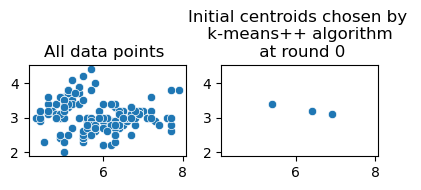

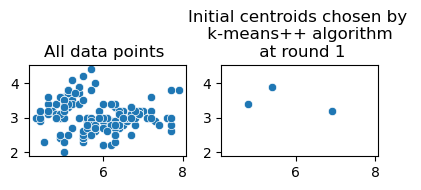

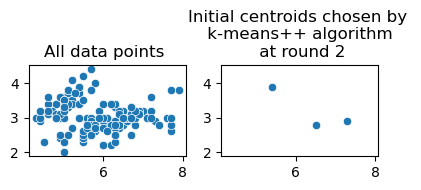

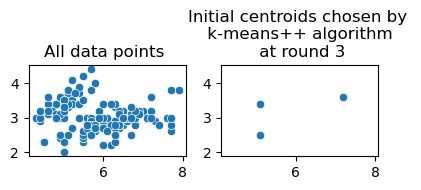

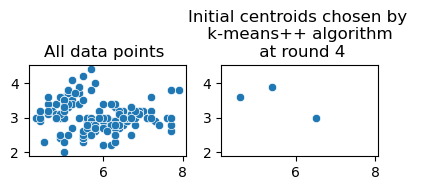

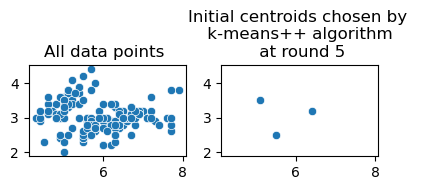

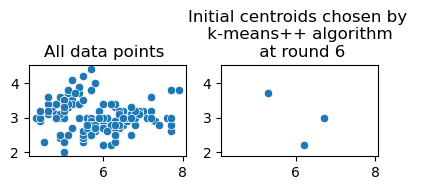

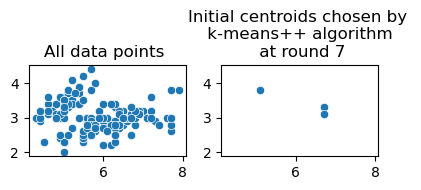

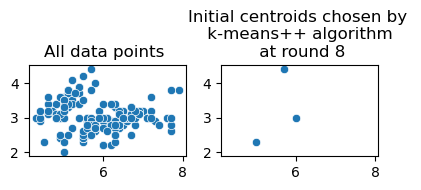

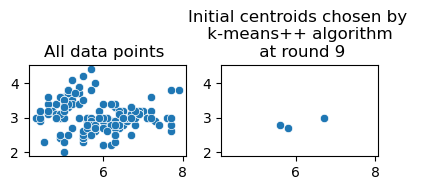

In [7]:
KM = KMeansClustering(k,centroids_algorithm=K_MEANS_PP_ALGORITHM,print_chosen_centroids = True)
KM.fit(X,rounds)
my_pred = KM.predict(X)

In [8]:
from sklearn.cluster import KMeans

In [9]:
SKM = KMeans(n_clusters=k,n_init=rounds,init=K_MEANS_PP_ALGORITHM,tol=0)
SKM.fit(X)
sk_pred = SKM.predict(X)

In [10]:
from sklearn.metrics import silhouette_score
%matplotlib inline

In [11]:
my_sil_score = np.round(silhouette_score(X,my_pred),2)
sk_sil_score = np.round(silhouette_score(X,sk_pred),2)

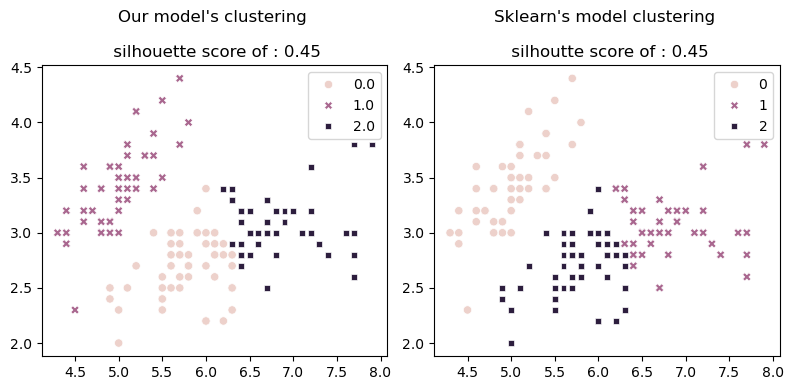

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=my_pred,style=my_pred, ax=axs[0])
axs[0].set_title("Our model's clustering \n\n silhouette score of : " + str(my_sil_score))

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=sk_pred,style=sk_pred, ax=axs[1])
axs[1].set_title("Sklearn's model clustering \n\n silhoutte score of : " + str(sk_sil_score))

plt.tight_layout()
plt.show()